# Imports

In [1]:
# Imports
from   IPython.display import display, HTML
import os
import h5py
import pandas as pd, datetime as dt, numpy as np, matplotlib.pyplot as plt
import seaborn as sns
from   pandas.tseries.offsets import DateOffset

# Display options
pd.set_option('display.width', 1000)
display(HTML("<style>.container { width:100% !important; }</style>"))
pd.set_option('mode.chained_assignment', None)

In [2]:
import mimicLOB as lob
from mimicLOB.agent.randomAgent import randomAgent
from apscheduler.schedulers.background import BackgroundScheduler

import requests
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sortedcontainers import SortedDict
from pprint import pprint
import time

# local server
localserver = "http://127.0.0.1:5000"

# distant server
distantserver = "http://mimiclob.appspot.com"

# Server used
server = localserver

# Executed Trades
executedtrades = SortedDict()

# pending Sent Orders 
pendingtrades = SortedDict()

# Get the LOB state

In [3]:
response = requests.get(f"{server}/getLOBstate")
tickSize =  requests.get(f"{server}/getticksize").json()['ticksize']
tickSize = 0.5

try:
    LOBstate = pd.read_json(response.json()['LOBstate']).set_index(['Price'])
    LOBstate.sort_index(inplace=True)
    minPrice = LOBstate.index[0]
    maxPrice = LOBstate.index[-1]
#     LOBstate = LOBstate.reindex(np.arange(minPrice, maxPrice, tickSize))
    LOBstate.columns = ['quantities']
    fig, ax = plt.subplots(1, 1, figsize = (30, 10))
    LOBstate.plot.bar(figsize=(30, 10), ax=ax)
#     ax.xaxis.set_major_locator(plt.MultipleLocator(tickSize*40))
#     ax.yaxis.set_major_locator(plt.MaxNLocator(3))
except:
    print('LOB is empty')

ConnectionError: HTTPConnectionPool(host='127.0.0.1', port=5000): Max retries exceeded with url: /getLOBstate (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x0000012928D86308>: Failed to establish a new connection: [WinError 10061] Aucune connexion n’a pu être établie car l’ordinateur cible l’a expressément refusée'))

## Reset Remote LOB

In [ ]:
response = requests.get(f"{server}/resetLOB").json()
response['status']

## Reset Remote LOB & Price & Transaction Tapes

In [ ]:
response = requests.get(f"{server}/reset").json()
response['status']

# Replay orders

## Data : 
- DTIME : le timestamp de l'ordre ;
- ORDER_ID : l'identifiant de l'ordre (que tu peux suivre en cas de changement dans la journée) ;
- PRICE 
- QTY
- ORDER_SIDE
- ITM : identifiant du trader
- ORDER_SIDE
- ORDER_TYPE :  <br>1 pour Market Order; <br>2 pour Limit Order; <br>q pour Quote <br> W pour Market On Open;
- ORDER_DURATION
- ACCOUNT_TYPE : type de client;
- PRODUCT_NAME : le nom du future et donc la maturité;
- SHORT_NAME : Maturité
- MONTHS_TO_EXPIRY
- INSTRUMENT_TYPE : F pour Future
- ACTION_TYPE : <br> I = limit order insertion (passive); <br> C = limit order cacnellations; <br> R = replace order that lose priority; <br> r = replace order that keeps priority; <br> S = replace order that makes the order aggressive (give rise to trade); <br> T = aggressive order (give rise to trade)
- MATCH_STRATEGY : True/False
- IS_OPEN_TRADE :  True/False
- BIDi, i=0,...,14 : prix bid à la i-ième limite du best bid
- BIDi_QTY, i=0,...,14 : quantité à la i-ième limite du best bid
- ASKi, i=0,...,14 : prix ask à la i-ième limite du best ask
- ASKi_QTY, i=0,...,14 : quantité à la i-ième limite du best ask
- SIGN : -1/1
- FRONT : True/False

In [ ]:
alldf = pd.read_hdf(r'data\day20160428.h5')

# Filters
ProductName = "JFFCE160500000F"
cols = ['DTIME', 'ORDER_ID', 'PRICE', 'QTY', 'ORDER_SIDE', 'ORDER_TYPE',
        'ORDER_DURATION', 'ACTION_TYPE', 'MATCH_STRATEGY', 'IS_OPEN_TRADE']

# Filter 
alldf = alldf[alldf.PRODUCT_NAME=="JFFCE160500000F"]
df = alldf[cols]

#Vizu
df.tail()

In [ ]:
len(df)

## Launch Trading

In [16]:
%%time

# replay orders
for i in df.index:
    if df.loc[i, 'ACTION_TYPE'] == 'C':
        side = df.loc[i, 'ORDER_SIDE']
        if side=='B':
            side = 'bid'
        else:
            side = 'ask'
        
        order_id = df.loc[i, 'ORDER_ID']
        params = {'side':side, 'id':int(order_id)}
        response = requests.get(f"{server}/cancelOrder",
                                json=params).json()
#         display(response['status'])
#         print(f'canceled order : {order_id}')
    elif ((df.loc[i, 'ACTION_TYPE'] == 'I') |(df.loc[i, 'ACTION_TYPE'] == 'T')):
        ordertype = df.loc[i, 'ORDER_TYPE']
        if ordertype==1:
            ordertype = 'market'
        else:
            ordertype = 'limit'

        side = df.loc[i, 'ORDER_SIDE']
        if side=='B':
            side = 'bid'
        else:
            side = 'ask'
        
        order_id = df.loc[i, 'ORDER_ID']
        order = {'type'      : ordertype, 
                 'side'      : side, 
                 'timestamp' : i,
                 'quantity'  : int(df.loc[i, 'QTY']),
                 'price'     : df.loc[i, 'PRICE'],
                 'order_id'  : int(order_id),
                 'trader_id'  : int(order_id)}
        
        response = requests.get(f"{server}/sendOrder", 
                        json=order).json()
        trades        = response['trades']
        pendingOrders = response['pendingOrders']
        
    elif ((df.loc[i, 'ACTION_TYPE'] == 'R') |(df.loc[i, 'ACTION_TYPE'] == 'r') |(df.loc[i, 'ACTION_TYPE'] == 'S')):
        ordertype = df.loc[i, 'ORDER_TYPE']
        if ordertype==1:
            ordertype = 'market'
        else:
            ordertype = 'limit'

        side = df.loc[i, 'ORDER_SIDE']
        if side=='B':
            side = 'bid'
        else:
            side = 'ask'
        
        order_id = df.loc[i, 'ORDER_ID']
        order = {'type'      : ordertype, 
                 'side'      : side, 
                 'quantity'  : int(df.loc[i, 'QTY']),
                 'price'     : df.loc[i, 'PRICE'],
                 'order_id'  : int(order_id),
                 'trader_id'  : int(order_id)}
        
        params = {}
        params['order'] = order
        params['order_id'] = int(order_id)
        params['time'] = i
        
        response = requests.get(f"{server}/modifyOrder", 
                        json=params).json()
#         print(response['status'])

#         print(f'executed order : {order_id}')

#     time.sleep(0.01)

KeyboardInterrupt: 

## Get Price Tape

'open : 4503.0'

'high : 4514.0'

'low : 4459.0'

'close : 4462.0'

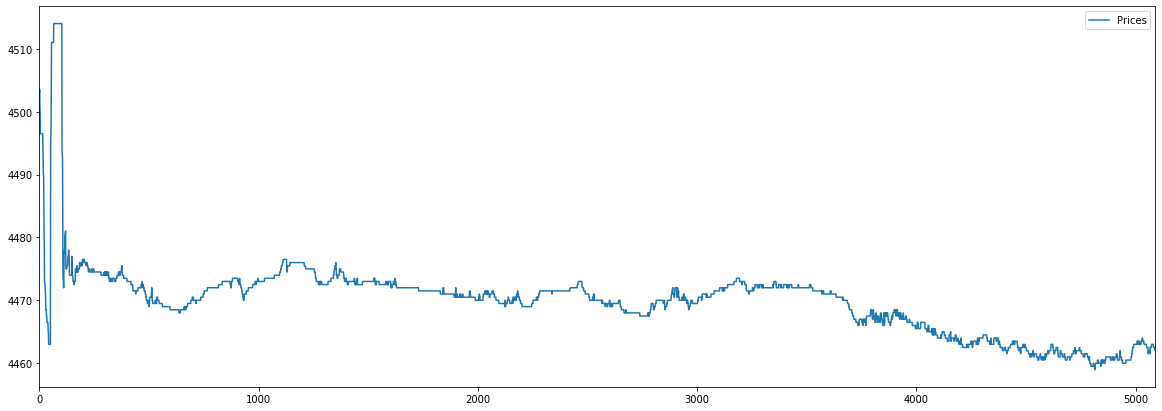

In [17]:
histoPrices = requests.get(f"{server}/getPriceTape",).json()['PriceTape']
histoPrices = pd.DataFrame([histoPrices]).T; histoPrices.columns = ['Prices']
histoPrices.plot(figsize=(20,7))
# display(histoPrices.describe())
display(f'open : {histoPrices.iloc[0,0]}')
display(f'high : {histoPrices.max()[0]}')
display(f'low : {histoPrices.min()[0]}')
display(f'close : {histoPrices.iloc[-1, 0]}')
plt.show()

## Get Transaction Tape

In [55]:
TransactionTape = requests.get(f"{server}/getTransactionTape").json()['TransactionTape']
TransactionTape = pd.read_json(TransactionTape)

In [56]:
TransactionTape #[TransactionTape.trader_id1==434884337166434913]

,time,party1_id,party1_side,party1_order_id,party2_id,party2_side,party2_order_id,traded_price,traded_quantity
0,1586704580883376800,434884337166434880,ask,434884337166434880,434884337166434924,ask,434884337166434924,4503.0,1
1,1586704581004055200,434884337166434943,bid,434884337166434943,434884337166434964,bid,434884337166434964,4503.5,1
2,1586704581004055200,434884337166434945,bid,434884337166434945,434884337166434964,bid,434884337166434964,4501.0,1
3,1586704581004055200,434884337166434941,bid,434884337166434941,434884337166434964,bid,434884337166434964,4500.0,4
4,1586704581015024600,434884337166434913,bid,434884337166434913,434884337166434966,bid,434884337166434966,4496.5,6
...,...,...,...,...,...,...,...,...,...
5087,1586704782154791800,434884337166478373,bid,434884337166478373,434884337166478383,bid,434884337166478383,4462.5,1
5088,1586704782311235500,434884337166478333,bid,434884337166478333,434884337166478410,bid,434884337166478410,4462.0,1
5089,1586704782324061900,434884337166478410,ask,434884337166478410,434884337166478412,ask,434884337166478412,4462.0,2
5090,1586704782339360500,434884337166478413,bid,434884337166478413,434884337166478415,bid,434884337166478415,4462.0,1


In [58]:
TransactionTape[TransactionTape.party2_order_id==434884337166442983]

,time,party1_id,party1_side,party1_order_id,party2_id,party2_side,party2_order_id,traded_price,traded_quantity
2369,1586704666762707400,434884337166453783,ask,434884337166453783,434884337166442983,ask,434884337166442983,4471.5,1
2370,1586704666762707400,434884337166453785,ask,434884337166453785,434884337166442983,ask,434884337166442983,4471.5,1
2371,1586704666762707400,434884337166454543,ask,434884337166454543,434884337166442983,ask,434884337166442983,4471.5,1


In [31]:
alldf.loc[27881-20:27881+10,:]

,DTIME,ORDER_ID,PRICE,QTY,ITM,ORDER_SIDE,ORDER_TYPE,ORDER_DURATION,ACCOUNT_TYPE,PRODUCT_NAME,...,ASK11,ASK11_QTY,ASK12,ASK12_QTY,ASK13,ASK13_QTY,ASK14,ASK14_QTY,SIGN,FRONT
27861,2016-04-28 07:35:56.405857,434884337166441336,4476.0,5,885,S,2,0,H,JFFCE160500000F,...,4475.0,16,4475.5,7,4476.0,12,4476.5,5,-1,True
27862,2016-04-28 07:35:56.406153,434884337166451650,4472.0,3,885,S,2,0,C,JFFCE160500000F,...,4475.0,16,4475.5,7,4476.0,17,4476.5,5,-1,True
27863,2016-04-28 07:35:56.406299,434884337166451713,4473.5,1,885,S,2,0,C,JFFCE160500000F,...,4475.0,16,4475.5,7,4476.0,17,4476.5,5,-1,True
27864,2016-04-28 07:35:56.406436,434884337166455354,4471.0,3,885,S,2,0,C,JFFCE160500000F,...,4475.0,16,4475.5,7,4476.0,17,4476.5,5,-1,True
27865,2016-04-28 07:35:56.406752,434884337166458139,4468.5,1,235,B,2,0,H,JFFCE160500000F,...,4475.0,16,4475.5,7,4476.0,17,4476.5,5,1,True
27866,2016-04-28 07:35:56.407341,434884337166457666,4471.5,1,1112,S,2,0,C,JFFCE160500000F,...,4475.0,16,4475.5,7,4476.0,17,4476.5,5,-1,True
27867,2016-04-28 07:35:56.408180,434884337166436898,4465.5,2,1106,B,2,0,C,JFFCE160500000F,...,4475.0,16,4475.5,7,4476.0,17,4476.5,5,1,True
27868,2016-04-28 07:35:56.408241,434884337166447581,4464.5,4,1106,B,2,0,C,JFFCE160500000F,...,4475.0,16,4475.5,7,4476.0,17,4476.5,5,1,True
27869,2016-04-28 07:35:56.408280,434884337166445779,4472.5,1,1106,S,2,0,C,JFFCE160500000F,...,4475.0,16,4475.5,7,4476.0,17,4476.5,5,-1,True
27870,2016-04-28 07:35:56.408306,434884337166445786,4473.5,1,1106,S,2,0,C,JFFCE160500000F,...,4475.0,16,4475.5,7,4476.0,17,4476.5,5,-1,True


In [59]:
df[(df.ORDER_ID==434884337166453783)].tail(20)

,DTIME,ORDER_ID,PRICE,QTY,ORDER_SIDE,ORDER_TYPE,ORDER_DURATION,ACTION_TYPE,MATCH_STRATEGY,IS_OPEN_TRADE
22489,2016-04-28 07:28:48.115303,434884337166453783,4471.5,1,S,2,0,I,False,False


In [34]:
import xlwings
xlwings.view(alldf[alldf.ORDER_ID==434884337166442982].T)

In [70]:
xlwings.view(alldf.iloc[-100000:-1,:].loc[:, newcols])

In [37]:
newcols = ['DTIME', 'ORDER_ID', 'PRICE', 'QTY', 'ORDER_SIDE', 'ORDER_TYPE', 'ACTION_TYPE', 'BID14', 'BID14_QTY', 'BID13', 'BID13_QTY', 'BID12', 'BID12_QTY', 'BID11', 'BID11_QTY', 'BID10', 'BID10_QTY', 'BID9', 'BID9_QTY', 'BID8', 'BID8_QTY', 'BID7', 'BID7_QTY', 'BID6', 'BID6_QTY', 'BID5', 'BID5_QTY', 'BID4', 'BID4_QTY', 'BID3', 'BID3_QTY', 'BID2', 'BID2_QTY', 'BID1', 'BID1_QTY', 'BID0', 'BID0_QTY', 'ASK0', 'ASK0_QTY', 'ASK1', 'ASK1_QTY', 'ASK2', 'ASK2_QTY', 'ASK3', 'ASK3_QTY', 'ASK4', 'ASK4_QTY', 'ASK5', 'ASK5_QTY', 'ASK6', 'ASK6_QTY', 'ASK7', 'ASK7_QTY', 'ASK8', 'ASK8_QTY', 'ASK9', 'ASK9_QTY', 'ASK10', 'ASK10_QTY', 'ASK11', 'ASK11_QTY', 'ASK12', 'ASK12_QTY', 'ASK13', 'ASK13_QTY', 'ASK14', 'ASK14_QTY', 'SIGN', 'FRONT']

In [61]:
alldf.head()

,DTIME,ORDER_ID,PRICE,QTY,ITM,ORDER_SIDE,ORDER_TYPE,ORDER_DURATION,ACCOUNT_TYPE,PRODUCT_NAME,...,ASK11,ASK11_QTY,ASK12,ASK12_QTY,ASK13,ASK13_QTY,ASK14,ASK14_QTY,SIGN,FRONT
0,2016-04-28 06:04:00.002845,434884337166225159,4479.5,2,761,B,2,1,C,JFFCE160500000F,...,0.0,0,0.0,0,0.0,0,0.0,0,1,True
1,2016-04-28 06:04:00.002845,434884337166432696,4486.5,1,761,B,2,1,C,JFFCE160500000F,...,0.0,0,0.0,0,0.0,0,0.0,0,1,True
2,2016-04-28 06:04:00.002846,434884337165906933,4467.5,2,761,B,2,1,C,JFFCE160500000F,...,0.0,0,0.0,0,0.0,0,0.0,0,1,True
3,2016-04-28 06:04:00.002846,434884337166432748,4466.5,1,761,B,2,1,C,JFFCE160500000F,...,0.0,0,0.0,0,0.0,0,0.0,0,1,True
4,2016-04-28 06:04:00.002847,434884337160615272,4452.5,1,429,B,2,1,C,JFFCE160500000F,...,0.0,0,0.0,0,0.0,0,0.0,0,1,True


In [63]:
from sortedcontainers import SortedDict
l = SortedDict()
l[1] = 'lol1'
l[0] = 'lol0'
l.keys()

SortedKeysView(SortedDict({0: 'lol0', 1: 'lol1'}))

In [66]:
for i in l.keys()[::-1]:
    print(i)

1
0


In [64]:
{i:'lol', i+1:'lool' for i in range(10)}

SyntaxError: invalid syntax (<ipython-input-64-4fb46a95c639>, line 1)